In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import random

from numpy import genfromtxt
from scipy import stats

In [67]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    # 아래꺼 np.c_만 하면 되는거 아닌가? reshape는 왜하지
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

def str_to_int(df):
    str_columns = df.select_dtypes(['object']).columns
    print(str_columns)
    for col in str_columns:
        df[col] = df[col].astype('category')

    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [68]:
def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', header=None)
    return df

     0  1  2  3  4  5  6  7  8  9  ... 13 14 15 16 17 18 19 20 21 22
8119  e  k  s  n  f  n  a  c  b  y ...  s  o  o  p  o  o  p  b  c  l
8120  e  x  s  n  f  n  a  c  b  y ...  s  o  o  p  n  o  p  b  v  l
8121  e  f  s  n  f  n  a  c  b  n ...  s  o  o  p  o  o  p  b  c  l
8122  p  k  y  n  f  y  f  c  n  b ...  k  w  w  p  w  o  e  w  v  l
8123  e  x  s  n  f  n  a  c  b  y ...  s  o  o  p  o  o  p  o  c  l

[5 rows x 23 columns]
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22],
           dtype='int64')
      0   1   2   3   4   5   6   7   8   9  ...  13  14  15  16  17  18  19  \
8119   0   3   2   4   0   5   0   0   0  11 ...   2   5   5   0   1   1   4   
8120   0   5   2   4   0   5   0   0   0  11 ...   2   5   5   0   0   1   4   
8121   0   2   2   4   0   5   0   0   0   5 ...   2   5   5   0   1   1   4   
8122   1   3   3   4   0   8   1   0   1   0 ...   1   7   7   0   2   1   0   
8123   0   5   2   4

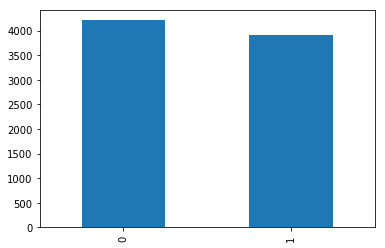

In [69]:
df = read_data('agaricus-lepiota.data')
print(df.tail())
df = str_to_int(df)
print(df.tail())
df[0].value_counts().sort_index().plot('bar')

In [70]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1:].values
print(stats.describe(features).variance)
print(features.shape, labels.shape)

[  0.24970776   2.57387182   1.51258643   6.48120427   0.24289959
   4.42567606   0.02518425   0.13543225   0.21362444  12.53414165
   0.24551327   1.12594609   0.38621168   0.45694105   3.61664276
   3.63776071   0.           0.05888829   0.07347592   3.246022
   5.67708411   1.56770888]
(8124, 22) (8124, 1)


In [71]:
features = feature_normalize(features)
print(stats.describe(features).variance)

[ 1.00012311  1.00012311  1.00012311  1.00012311  1.00012311  1.00012311
  1.00012311  1.00012311  1.00012311  1.00012311  1.00012311  1.00012311
  1.00012311  1.00012311  1.00012311  1.00012311         nan  1.00012311
  1.00012311  1.00012311  1.00012311  1.00012311]


C:\Users\deera\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [72]:
rnd_indices = np.random.rand(len(features)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

feature_count = train_x.shape[1]
label_count = train_y.shape[1]
print(feature_count, label_count)

22 1


In [73]:
training_epochs = 1000
learning_rate = 0.01
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = len(df[0].unique())

X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot_5:0", shape=(?, 1, 2), dtype=float32)
reshape Tensor("Reshape_14:0", shape=(?, 2), dtype=float32)


In [74]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, p_keep_input, p_keep_hidden): # this network is the same as the previous one except with an extra hidden layer + dropout
    s_1 = feature_count * 3
    s_2 = feature_count
    
    X = tf.nn.dropout(X, p_keep_input)
    w_h = init_weights([feature_count, s_1])
    b = tf.Variable(tf.random_normal([s_1]))
    h = tf.nn.relu(tf.matmul(X, w_h) + b)
    
    h = tf.nn.dropout(h, p_keep_hidden)
    w_h2 = init_weights([s_1, s_2])
    b2 = tf.Variable(tf.random_normal([s_2]))
    h2 = tf.nn.relu(tf.matmul(h, w_h2) + b2)
    
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    w_o = init_weights([s_2, nb_classes])
    b_o = tf.Variable(tf.random_normal([nb_classes]))
    return tf.matmul(h2, w_o) + b_o

In [75]:
p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

h0 = model(X, p_keep_input, p_keep_hidden)

In [76]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [77]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [78]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(X.shape, Y.shape)
training_dropout_i = 0.8
training_dropout_h = 0.6
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        cost_history = np.append(cost_history, acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x, 
                                                         p_keep_input: 1.0,
                                                         p_keep_hidden: 1.0}))

(5707, 22) (5707, 1)
(2417, 22) (2417, 1)
(?, 22) (?, 1)
Step:     0	Loss: 0.533	Acc: 73.10%
Step:   100	Loss: 0.453	Acc: 67.81%
Step:   200	Loss: 0.452	Acc: 67.58%
Step:   300	Loss: 0.452	Acc: 67.15%
Step:   400	Loss: 0.454	Acc: 66.58%
Step:   500	Loss: 0.460	Acc: 65.90%
Step:   600	Loss: 0.453	Acc: 67.20%
Step:   700	Loss: 0.455	Acc: 67.41%
Step:   800	Loss: 0.455	Acc: 65.73%
Step:   900	Loss: 0.452	Acc: 67.76%
Step:  1000	Loss: 0.455	Acc: 65.32%
(2417,)
Test Accuracy: 0.383533


(1002,)


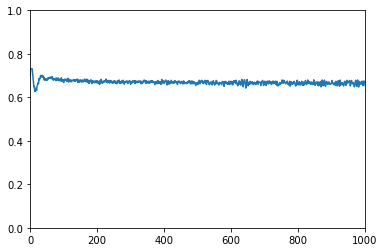

In [79]:
print(cost_history.shape)
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [80]:
sess.close()